### Install and import the required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
# Installing pystan (may take around 8 minutes if the package is not in the environment yet)
t = time.time()
!pip install pystan==2.19.0.0
print('Time elapsed: {} seconds'.format(time.time() - t))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.0.0-cp38-cp38-linux_x86_64.whl size=61787612 sha256=31f7f19cf6b79d734ceb89828af2d4b597cfe2edc56255ed4de29350221669dc
  Stored in directory: /root/.cache/pip/wheels/92/af/46/7a021b32f4f0dec5d0a7b669e13b95a40a62ce007ac1039442
Successfully built pystan
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Time elapsed: 482.15744829177856 seconds


In [3]:
import pystan

In [4]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rc('font', size=16)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)

### Input your data of interest

In [5]:
# For example:
X = np.array([0., 0.01, 0.03, 0.1, 0.3, 1.])
Y = np.array([100., 96.1, 91.6, 78.2, 62.3, 40.8])
print('dosage: ', X, 'response: ', Y)

dosage:  [0.   0.01 0.03 0.1  0.3  1.  ] response:  [100.   96.1  91.6  78.2  62.3  40.8]


In [ ]:
# Alternatively, upload dataset in the form of a .csv file, where the first 
# column is named "dosage", and the second column is named "response".
df = pd.read_csv("your_dose_response_data.csv")
X = df["dosage"]
Y = df["response"]

### Define the model according to Box 1 in the paper

#### Notes:
 - The prior for $E_0$ is defined to be Gaussian with mean $100$ and a standard deviation of $3$ (i.e. $B=100$ where $B$ is
 defined in the paper). But this may need to be changed according to the range of the responses in the dataset. For example, if the response range
 is between $0$ and $1$, then the prior for $E_0$ below shall be changed from `e0 ~ normal(100, 3)` to `e0 ~ normal(1, 0.03)`,
 or some standard deviation other than $0.03$ (but the mean needs to be $1$).
 - The Beta prior for the normalised $\text{E}_{\text{inf}}$ is defined according to Option 2 in the paper. To opt for
 Option 1, change the prior for `einf` below from `einf ~ beta(0.46, 0.58)` to `einf ~ uniform(0, 1)`.
 - The bounds for the prior of $\log C$ are defined according to the dosage range of the AstraZeneca-Sanger DREAM challenge.
 Please refer to the paper for information on how to adjust the bounds (if necessary).

In [6]:
model = """
data {
  int<lower=0> N;
  int<lower=0> N_test;
  vector[N] X;
  vector[N] Y;
  vector[N_test] X_test;
}
parameters {
  real<lower=0> e0;
  real<lower=0, upper=1> einf;
  real<lower=log(1e-10), upper=log(1e6)> logC;
  real<lower=0> h;
  real<lower=0> sigma;
}
model {
    h ~ lognormal(0, 1);
    einf ~ beta(0.46, 0.58);
    sigma ~ lognormal(0, 1);
    e0 ~ normal(100, 3);
    for(i in 1:N)
    Y[i] ~ normal( e0 + (einf * e0 - e0) / (1.0 + (exp(logC) / X[i]) ^ h), sigma);
}
generated quantities {
    vector[N_test] Y_synthetic;
    for(i in 1:N_test){
        Y_synthetic[i] = normal_rng( e0 + (einf * e0 - e0) / (1.0 + (exp(logC) / X_test[i]) ^ h), sigma);
    }
}
"""

In [7]:
def synba_train(sm, X, Y, X_test=None, Y_test=None, iter=1000, chains=4, 
                warmup=500, adapt_delta=0.9):
  N = len(Y)
  # Add a tiny value to the zeros.
  zero_ind = np.where(X == 0)[0]
  X[zero_ind] = np.minimum(1e-8, 0.001 * np.min(X[np.where(X>0)[0]]))
  if X_test is None:
    N_test, X_test = N, X
  data = {'N': N, 'X': X, 'Y': Y, 'N_test': N_test, 'X_test': X_test}
  fit = sm.sampling(data=data, iter=iter, chains=chains, warmup=warmup, thin=1, 
                    seed=101, control=dict(adapt_delta=adapt_delta))
  return fit

### Compile and train the model

In [8]:
# Compile the model (may take around 1-2 minutes)
# Note: This cell only needs to be run once! As long as the definition for the
# model above is unchanged, this cell does not need to be repeated, even for
# different datasets.
t = time.time()
sm = pystan.StanModel(model_code=model)
print('Time taken to compile the model: {} seconds'.format(time.time() - t))

Time elapsed: 104.68464660644531 seconds


In [9]:
# Fit the model and generate samples
t = time.time()
fit = synba_train(sm, X, Y)
print('Time taken to fit the model: {} seconds'.format(time.time() - t))

Time taken to fit the model: 0.8132009506225586 seconds


### Output Analysis

#### Summary statistics
Note: The "einf" in the summary table is normalised, so its range is (0, 1) instead of (0, e0).

In [10]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], columns=summary_dict['summary_colnames'],
                  index=summary_dict['summary_rownames'])
# Extracting traces
e0, einf, logC, h, sigma = fit['e0'], fit['einf'], fit['logC'], fit['h'], fit['sigma']

print(fit.stansummary())

Inference for Stan model: anon_model_e7124fe2c3ecfc440c91569b6ead6227.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
e0             100.19    0.04   0.89  98.23  99.71  100.2 100.71 101.98    559   1.01
einf              0.1  4.4e-3   0.07 4.1e-4   0.03   0.09   0.14   0.26    274   1.01
logC            -0.81    0.01   0.22  -1.33  -0.96  -0.79  -0.63  -0.48    280   1.01
h                0.81  4.1e-3   0.07    0.7   0.76    0.8   0.84   0.98    287   1.01
sigma            1.08    0.03   0.52   0.48   0.72   0.94   1.29   2.45    377   1.01
Y_synthetic[1] 100.22    0.04   1.53  97.22  99.43 100.25 101.03 103.18   1362    1.0
Y_synthetic[2]  95.99    0.04   1.42  93.12  95.26  95.99  96.76  98.83   1174    1.0
Y_synthetic[3]  90.79    0.04   1.39  87.79  90.06   90.8  91.56  93.49   1552    1.0
Y_synthetic[4]  79.13    0.03   1.45  7

#### Output visualisation
Note: Tune the A and B for different sizes of the histograms for Emax and IC50.

Red histogram: The posterior distribution for IC50.
Green histogram: The posterior distribution for Emax.
Light blue curves: Sample dose-response curves from the posterior.
Red bell curves: The estimated noise level for the responses.


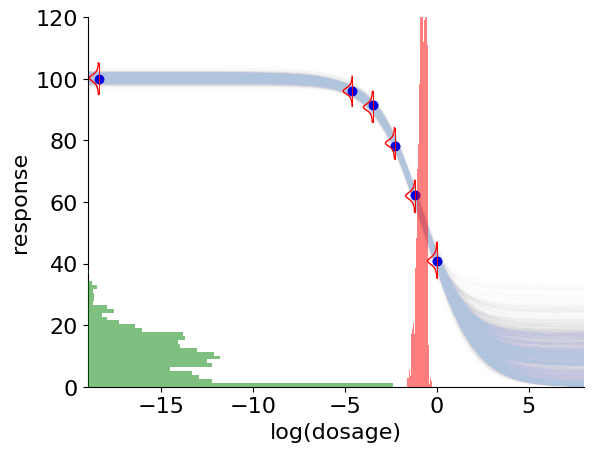

In [12]:
A, B = 1.5, 0.2
print("Red histogram: The posterior distribution for IC50.")
print("Green histogram: The posterior distribution for Emax.")
print("Light blue curves: Sample dose-response curves from the posterior.")
print("Red bell curves: The estimated noise level for the responses.")

# Plotting regression line
log_x_min, log_x_max = int(np.floor(np.log(np.min(X)))), int(np.ceil(np.log(np.max(X)))) + 8
log_x_plot = np.linspace(log_x_min, log_x_max, 100)
yy_max = np.repeat(-100, 6)
yy_min = np.repeat(100, 6)

fig, ax1 = plt.subplots()
# Plot the sampled regression lines
for i in range(len(e0)):
    yy = e0[i] + (einf[i] * e0[i] - e0[i]) / (1.0 + (np.exp(logC[i]) / np.exp(log_x_plot)) ** h[i])
    ax1.plot(log_x_plot, yy, color='lightsteelblue', alpha=0.005)
    yy_x = e0[i] + (einf[i] * e0[i] - e0[i]) / (1.0 + (np.exp(logC[i]) / X) ** h[i])
    yy_max = np.maximum(yy_max, yy_x + sigma[i])
    yy_min = np.minimum(yy_min, yy_x - sigma[i])
for i in range(6):
    support = np.linspace(yy_min[i], yy_max[i], 100)
    p_x = np.zeros(np.shape(support))
    for j in range(len(e0)):
        delta_support = support - (e0[j] + (einf[j] * e0[j] - e0[j]) / (1.0 + (np.exp(logC[j]) / X[i]) ** h[j]))
        gaussian = np.exp((-delta_support ** 2.0) / (2 * sigma[j] ** 2.0))
        gaussian *= -1
        p_x += gaussian
    p_x = p_x / np.max(np.abs(p_x)) * 0.5
    ind = np.where(np.abs(p_x)>0.01)[0]
    ax1.plot(p_x[ind] + np.log(X[i]), support[ind], c='red', linewidth=1)
    ax1.plot(np.zeros_like(p_x[ind]) + np.log(X[i]), support[ind], c='red', linewidth=0.7)

# Plot the original data
ax1.scatter(np.log(X), Y, c='blue')
ax1.set_xlabel('log(dosage)')
ax1.set_ylabel('response')
ax1.set_xlim(log_x_min, log_x_max)
ax1.set_ylim(0, 120)

# Plot data
ax1.scatter(np.log(X), Y, c='blue')

# Plot IC50 (with direct histogram)
ax2 = ax1.twinx()
ax2.axis('off')
ax2.hist(logC, 30, density=True, color='r', alpha=0.5)
ax2.set_ylim(0, A)

# Plot Emax (with direct histogram)
einf_rescaled = einf * e0
ax3x = ax1.twinx()
ax3 = ax3x.twiny()
ax3.hist(einf_rescaled, 30, density=True, color='green', alpha=0.5, orientation="horizontal")
ax3.set_xlim(0, B)
ax3.set_ylim(0, 120)
ax3x.axis('off')
ax3.axis('off')

plt.show()